<a href="https://colab.research.google.com/github/khangsheng1/Learning-PyTorch/blob/main/CC_Fraud_Kaggle/CC_Fraud_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

{}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory


In [25]:
import os
import torch
import torch.nn as nn
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!kaggle datasets download -d mlg-ulb/creditcardfraud -p ./datasets/

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# Define the path to your zip file
zip_file_path = './datasets/creditcardfraud.zip'
extracted_path = './datasets/extracted/'

# Check if the file exists
if os.path.exists(zip_file_path):
    # Open the zip file in read mode
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents of the zip file to a directory
        zip_ref.extractall(extracted_path)
        print(f'Files extracted to: {extracted_path}')
else:
    print("Zip file does not exist.")

Files extracted to: ./datasets/extracted/


In [6]:
# Assuming there's a CSV file in the extracted folder
csv_file_path = os.path.join(extracted_path, 'creditcard.csv')

# Load the CSV into a pandas DataFrame
if os.path.exists(csv_file_path):
    df = pd.read_csv(csv_file_path)
    print(df.head())  # Print the first 5 rows of the DataFrame
else:
    print("CSV file not found.")

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [7]:
df.shape

(284807, 31)

In [8]:
# Separate into X and y
X = df.drop(columns=['Time','Class'])
y = df['Class']

# Check the shape of X and y to ensure they're correct
print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (284807, 29)
Labels shape: (284807,)


In [9]:
# Perform an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the DataFrames to PyTorch tensors
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

# Check the shapes of the tensors
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([227845, 29])
X_test shape: torch.Size([56962, 29])
y_train shape: torch.Size([227845])
y_test shape: torch.Size([56962])


In [10]:
# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'You are using {device}.')

You are using cpu.


In [11]:
# Move tensors to the appropriate device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Verify the device of the tensors
print(f"X_train is on: {X_train.device}")
print(f"X_test is on: {X_test.device}")
print(f"y_train is on: {y_train.device}")
print(f"y_test is on: {y_test.device}")

X_train is on: cpu
X_test is on: cpu
y_train is on: cpu
y_test is on: cpu


In [12]:
# Check the distribution of the target variable y
class_distribution = y.value_counts()

print(class_distribution)

Class
0    284315
1       492
Name: count, dtype: int64


This disproportionately non-fraud.

Solution: oversampling the minority class
*   Reasoning: Oversampling increases the number of fraud cases in your training data by duplicating or synthesizing new fraud examples. This balances the class distribution and gives the model more opportunities to learn from fraudulent patterns.


In [13]:
from imblearn.over_sampling import RandomOverSampler

# Create an oversampler object
ros = RandomOverSampler(random_state=42)

# Resample the training data
X_train, y_train = ros.fit_resample(X_train.cpu(), y_train.cpu())

# Convert the resampled data back to PyTorch tensors and move to device
X_train = torch.tensor(X_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([454902, 29])
y_train shape: torch.Size([454902])


In [21]:
# Build model

class CC_Fraud_Model(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=10):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features) # Output should be 1 for binary classification
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

input_features = X_train.shape[1]
print(input_features)
# unique_classes = torch.unique(y_test) # This is causing the issue.
# unique_classes.numel() # You want 1 output for binary classification
# print(unique_classes.numel())

# Create instance of model
#Change the output_features to 1 for binary classification
model = CC_Fraud_Model(input_features=X_test.shape[1],output_features=1,hidden_units=20)
model.to(device)
print(model)
print(f"Model is on: {next(model.parameters()).device}")

29
CC_Fraud_Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=29, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Model is on: cpu


In [22]:
# Create loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
torch.manual_seed(42)
epochs = 250

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []
epoch_count = []

for epoch in range(epochs):

  # Put model in training mode
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze() # squeeze to remove extra dimension
  y_pred = torch.round(torch.sigmoid(y_logits)) # ensure y_pred and y_train have the same shape

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train) # y_logits and y_train should now have compatible shapes
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  # Testing

  # Put model into evaluation mode
  model.eval()

  with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze() # squeeze to remove extra dimension
      test_pred = torch.round(torch.sigmoid(test_logits))# ensure test_pred and y_test have the same shape
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)# test_logits and y_test should now have compatible shapes
      test_acc = accuracy_fn(y_true=y_test,
                              y_pred=test_pred)


  # Print out what's happening
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.item())
    test_loss_values.append(test_loss.item())
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.22627, Accuracy: 50.23% | Test Loss: 1.0306, Test Acc: 47.79%
Epoch: 10 | Loss: 0.65403, Accuracy: 74.54% | Test Loss: 0.80116, Test Acc: 60.03%
Epoch: 20 | Loss: 0.61862, Accuracy: 81.09% | Test Loss: 0.79134, Test Acc: 60.62%
Epoch: 30 | Loss: 0.59236, Accuracy: 84.53% | Test Loss: 0.80531, Test Acc: 58.48%
Epoch: 40 | Loss: 0.58129, Accuracy: 85.12% | Test Loss: 0.89944, Test Acc: 56.00%
Epoch: 50 | Loss: 0.56434, Accuracy: 85.58% | Test Loss: 0.84123, Test Acc: 60.16%
Epoch: 60 | Loss: 0.54073, Accuracy: 87.12% | Test Loss: 0.84761, Test Acc: 62.13%
Epoch: 70 | Loss: 0.52837, Accuracy: 87.18% | Test Loss: 0.80919, Test Acc: 65.36%
Epoch: 80 | Loss: 0.50492, Accuracy: 88.88% | Test Loss: 0.75539, Test Acc: 70.66%
Epoch: 90 | Loss: 0.48117, Accuracy: 89.87% | Test Loss: 0.71317, Test Acc: 76.86%
Epoch: 100 | Loss: 0.51478, Accuracy: 86.62% | Test Loss: 0.65024, Test Acc: 87.18%
Epoch: 110 | Loss: 0.44879, Accuracy: 91.83% | Test Loss: 0.73404, Test Acc: 74.39%
Epoc

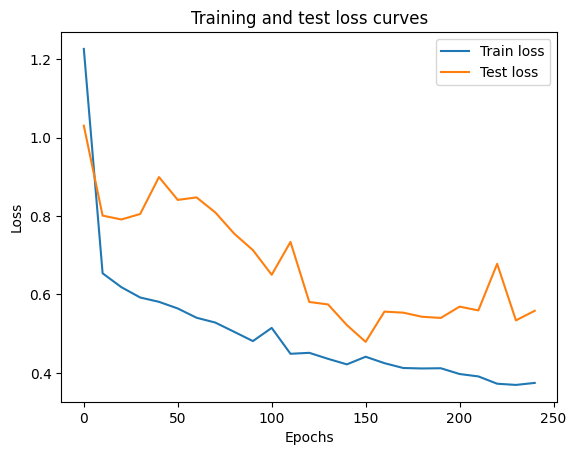

In [26]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [18]:
test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

In [19]:
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 99.49%


In [20]:
# Collect the test data with fraud
fraud_index = torch.where(y_test == 1)[0]

# Get a random index from fraud_index
random_fraud_index = random.choice(fraud_index.tolist())

# Use fraud index in model
model.eval()
with torch.inference_mode():
    # Forward pass
    y_logits = model(X_test[random_fraud_index])
    y_pred = torch.round(torch.sigmoid(y_logits))
    print(f"Test indes: {random_fraud_index}, Predicted: {y_pred.item()}, Actual: {y_test[random_fraud_index].item()}")


Test indes: 16592, Predicted: 1.0, Actual: 1.0
